In [8]:
!pip install -q datasets tensorflow

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
import re

from google.colab import drive
drive.mount('/content/drive')

# Change le chemin de sauvegarde vers ton Drive
checkpoint_filepath = "/content/drive/MyDrive/mon_meilleur_transformer.keras"

# Chargement du dataset
# Note: "dair-ai/emotion" est le chemin complet officiel sur le Hub
dataset = load_dataset("dair-ai/emotion")

# Aperçu
print("Exemple de donnée brute :", dataset['train'][1])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Exemple de donnée brute : {'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0}


In [10]:
# 1. Nettoyage du texte
def custom_standardization(input_data):
    # Conversion en minuscule
    lowercase = tf.strings.lower(input_data)
    # Suppression des URLs
    stripped_html = tf.strings.regex_replace(lowercase, r'http\S+', ' ')
    # Suppression des mentions (@user)
    no_mentions = tf.strings.regex_replace(stripped_html, r'@\w+', ' ')
    # Suppression des caractères spéciaux et nombres (garder seulement lettres et ponctuation basique)
    clean_text = tf.strings.regex_replace(no_mentions, r'[^a-z\s]', '')
    return clean_text

# 2. Préparation des listes pour Keras
# On convertit explicitement en np.array pour que TensorFlow comprenne le format
train_texts = np.array(dataset['train']['text'])
train_labels = np.array(dataset['train']['label'])

val_texts = np.array(dataset['validation']['text'])
val_labels = np.array(dataset['validation']['label'])

test_texts = np.array(dataset['test']['text'])
test_labels = np.array(dataset['test']['label'])

# 3. Paramètres de Tokenisation
VOCAB_SIZE = 20000  # Taille du vocabulaire
MAX_LEN = 100       # Longueur maximale d'un tweet

# Création de la couche de vectorisation
vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN,
    standardize=custom_standardization
)

# Adapter le vectorizer sur les données d'entraînement (création de l'index vocabulaire)
vectorizer.adapt(train_texts)

# 4. Conversion des datasets en tf.data.Dataset pour la performance
batch_size = 32

def format_dataset(texts, labels):
    # Vectorisation des textes
    texts = vectorizer(texts)
    # Création du dataset
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = format_dataset(train_texts, train_labels)
val_ds = format_dataset(val_texts, val_labels)
test_ds = format_dataset(test_texts, test_labels)

print("Données prêtes et vectorisées.")

Données prêtes et vectorisées.


In [12]:
# --- Paramètres du Modèle ---
EMBED_DIM = 32      # Dimension de l'embedding
NUM_HEADS = 2       # Nombre de têtes d'attention
FF_DIM = 32         # Dimension du réseau feed-forward interne
NUM_CLASSES = 6     # Le dataset "emotion" a 6 classes (sadness, joy, love, anger, fear, surprise)

# --- Classe 1 : L'encodeur Transformer ---
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        # Attention Multi-têtes
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed Forward Network
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # Normalisation et Dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Attention
        attn_output = self.att(inputs, inputs)
        # On passe le booléen training aux dropouts
        attn_output = self.dropout1(attn_output, training=training)
        # Connexion résiduelle
        out1 = self.layernorm1(inputs + attn_output)

        # Feed Forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Connexion résiduelle
        return self.layernorm2(out1 + ffn_output)

# --- Classe 2 : Embedding + Position ---
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# --- Assemblage du Modèle Final ---
inputs = layers.Input(shape=(MAX_LEN,))
embedding_layer = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBED_DIM)
x = embedding_layer(inputs)

transformer_block = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM)
x = transformer_block(x)

# On réduit la dimension temporelle (moyenne globale)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)

# Couche de sortie (Softmax pour multi-classe)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 100, 32)        │       643,200 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 100, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,642 (2.50 MB)

 Trainable params: 654,642 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compilation
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Définition du chemin de sauvegarde (format .keras recommandé par TensorFlow récent)
# checkpoint_filepath = "mon_meilleur_transformer.keras"

# Création du Callback de sauvegarde
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,    # On sauvegarde tout le modèle (architecture + poids)
    monitor='val_accuracy',     # On surveille la précision sur la validation
    mode='max',                 # On veut que la précision soit la plus haute possible
    save_best_only=True,        # On ne sauvegarde que si le modèle est meilleur que le précédent
    verbose=1                   # Affiche un message quand il sauvegarde
)

# Ajout d'un EarlyStopping pour gagner du temps (arrête si ça ne progresse plus)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,                 # Arrête si pas d'amélioration après 3 époques
    restore_best_weights=True
)

# Entraînement avec les callbacks
history = model.fit(
    train_ds,
    batch_size=32,
    epochs=25,                  # Tu peux mettre plus d'époques, il s'arrêtera tout seul grâce à l'EarlyStopping
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/25
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9394 - loss: 0.1884
Epoch 1: val_accuracy improved from -inf to 0.90900, saving model to /content/drive/MyDrive/mon_meilleur_transformer.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9394 - loss: 0.1883 - val_accuracy: 0.9090 - val_loss: 0.2989
Epoch 2/25
483/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9518 - loss: 0.1439
Epoch 2: val_accuracy did not improve from 0.90900
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9519 - loss: 0.1436 - val_accuracy: 0.8925 - val_loss: 0.3752
Epoch 3/25
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9679 - loss: 0.1045
Epoch 3: val_accuracy did not improve from 0.90900
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9679 - loss: 0.1044 - val_accuracy: 0.8935 - val_loss: 0.4310
Epoch 4/25
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9758 - loss: 0.0806
Epoch 4: val_accuracy did not improve from 0.90900
500/500 ━━━━━━━━━━━━━━━━━━━━

In [17]:
# Évaluation sur le jeu de test
print("\n--- Évaluation sur le jeu de Test ---")
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

# Dictionnaire des labels (basé sur la doc hugging face emotion)
label_int2str = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# Fonction de prédiction
def predict_emotion(text):
    # Vectorisation
    vectorized_text = vectorizer([text])
    # Prédiction
    prediction = model.predict(vectorized_text)
    # Récupération de l'index max
    predicted_index = np.argmax(prediction)
    confidence = np.max(prediction)

    emotion = label_int2str[predicted_index]
    print(f"Tweet: '{text}'")
    print(f"Prédiction: {emotion} ({confidence:.2%} de confiance)\n")

# Tests manuels
predict_emotion("I am so terrified of the dark.")
predict_emotion("I finally got the promotion, this is the best day ever!")
predict_emotion("I feel neglected and hurt by what you said.")


--- Évaluation sur le jeu de Test ---
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9017 - loss: 0.2941
Test Loss: 0.2970
Test Accuracy: 0.8950
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Tweet: 'I am so terrified of the dark.'
Prédiction: fear (99.62% de confiance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tweet: 'I finally got the promotion, this is the best day ever!'
Prédiction: anger (34.11% de confiance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tweet: 'I feel neglected and hurt by what you said.'
Prédiction: sadness (98.73% de confiance)



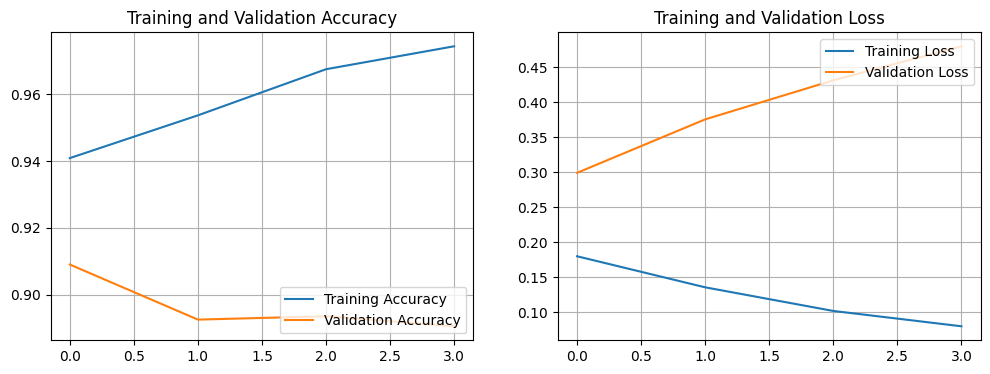

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. Courbes d'Apprentissage (Loss & Accuracy) ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.show()

# Affiche les courbes si l'historique existe
if 'history' in locals():
    plot_history(history)
else:
    print("La variable 'history' n'existe pas. Avez-vous lancé l'entraînement ?")

In [19]:
# --- 2. Prédictions sur le jeu de test ---
print("\nCalcul des prédictions sur le jeu de test...")
# On récupère les probabilités prédites
predictions = model.predict(test_ds)
# On prend l'index de la probabilité maximale (ex: [0.1, 0.8, 0.1] -> classe 1)
y_pred = np.argmax(predictions, axis=1)

# On récupère les vrais labels (test_labels a été défini plus haut comme np.array)
# Assurez-vous que test_labels correspond bien à l'ordre de test_ds (c'est le cas ici)
y_true = test_labels


Calcul des prédictions sur le jeu de test...
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


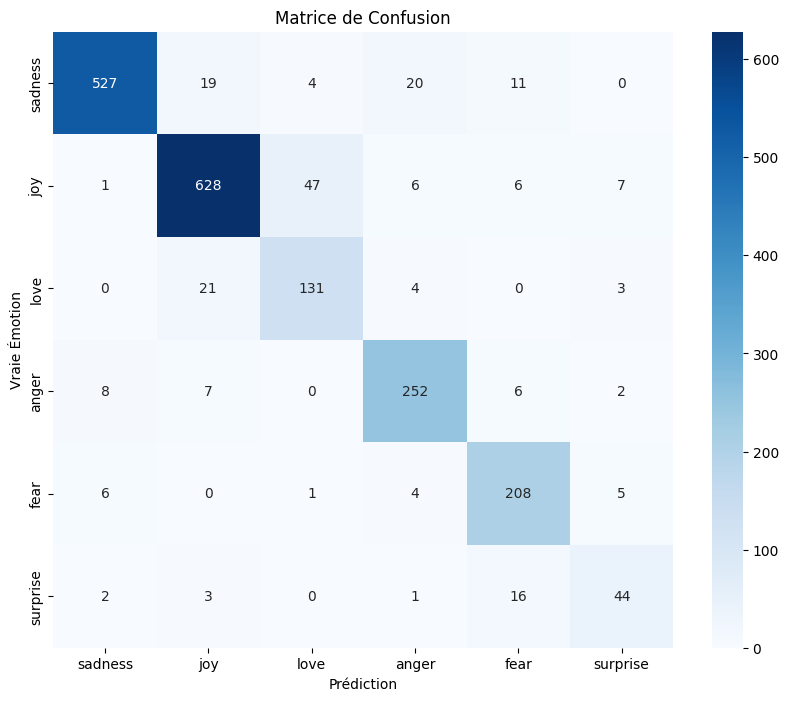

In [20]:
# --- 3. Matrice de Confusion ---
# Définition des noms de classes pour l'affichage
class_names = [label_int2str[i] for i in range(6)]

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédiction')
plt.ylabel('Vraie Émotion')
plt.title('Matrice de Confusion')
plt.show()


In [21]:

# --- 4. Rapport de Classification Détaillé ---
print("\n--- Rapport de Classification ---")
print(classification_report(y_true, y_pred, target_names=class_names))


--- Rapport de Classification ---
              precision    recall  f1-score   support

     sadness       0.97      0.91      0.94       581
         joy       0.93      0.90      0.91       695
        love       0.72      0.82      0.77       159
       anger       0.88      0.92      0.90       275
        fear       0.84      0.93      0.88       224
    surprise       0.72      0.67      0.69        66

    accuracy                           0.90      2000
   macro avg       0.84      0.86      0.85      2000
weighted avg       0.90      0.90      0.90      2000

